Matplotlib is building the font cache; this may take a moment.


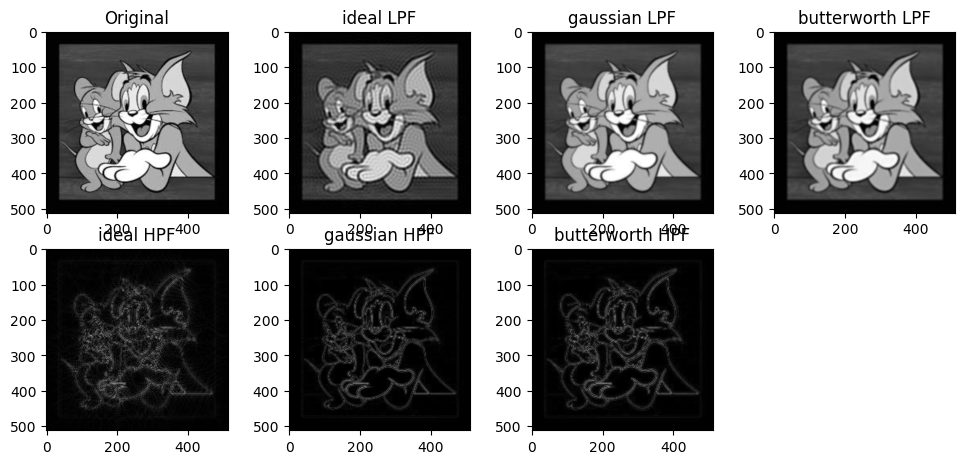

Low-Pass Filter (ideal) - MSE: 0.0039, PSNR: 24.08 dB
Low-Pass Filter (gaussian) - MSE: 0.0020, PSNR: 26.90 dB
Low-Pass Filter (butterworth) - MSE: 0.0027, PSNR: 25.66 dB
High-Pass Filter (ideal) - MSE: 0.1700, PSNR: 7.70 dB
High-Pass Filter (gaussian) - MSE: 0.1842, PSNR: 7.35 dB
High-Pass Filter (butterworth) - MSE: 0.1806, PSNR: 7.43 dB


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path, size=(512, 512)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    img = np.float32(img) / 255.0  # Normalize pixel values
    return img

def apply_fft(img):
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    return dft, dft_shift

def apply_ifft(dft_shift):
    dft_ishift = np.fft.ifftshift(dft_shift)
    img_back = np.fft.ifft2(dft_ishift)
    img_back = np.abs(img_back)
    return img_back

def create_low_pass_filter(shape, D0, filter_type='gaussian', n=2):
    rows, cols = shape
    crow, ccol = rows // 2 , cols // 2
    
    H = np.zeros((rows, cols))
    for u in range(rows):
        for v in range(cols):
            D = np.sqrt((u - crow)**2 + (v - ccol)**2)
            if filter_type == 'ideal':
                H[u, v] = 1 if D <= D0 else 0
            elif filter_type == 'gaussian':
                H[u, v] = np.exp(-(D**2) / (2 * (D0**2)))
            elif filter_type == 'butterworth':
                H[u, v] = 1 / (1 + (D / D0) ** (2 * n))
    return H

def create_high_pass_filter(shape, D0, filter_type='gaussian', n=2):
    H = create_low_pass_filter(shape, D0, filter_type, n)
    return 1 - H

def apply_filter(dft_shift, H):
    return dft_shift * H

def compute_metrics(original, processed):
    mse = np.mean((original - processed) ** 2)
    psnr = 10 * np.log10(1 / mse) if mse != 0 else float('inf')
    return mse, psnr

# Load and Process Image
image_path = 'download.jpeg'
img = load_image(image_path)
dft, dft_shift = apply_fft(img)

# Apply Low-Pass Filters
D0 = 50
low_pass_filters = ['ideal', 'gaussian', 'butterworth']
filtered_images_lp = {}
for f_type in low_pass_filters:
    H_lp = create_low_pass_filter(img.shape, D0, f_type)
    filtered_dft_lp = apply_filter(dft_shift, H_lp)
    filtered_images_lp[f_type] = apply_ifft(filtered_dft_lp)

# Apply High-Pass Filters
high_pass_filters = ['ideal', 'gaussian', 'butterworth']
filtered_images_hp = {}
for f_type in high_pass_filters:
    H_hp = create_high_pass_filter(img.shape, D0, f_type)
    filtered_dft_hp = apply_filter(dft_shift, H_hp)
    filtered_images_hp[f_type] = apply_ifft(filtered_dft_hp)

# Display Results
plt.figure(figsize=(12, 8))
plt.subplot(3, 4, 1), plt.imshow(img, cmap='gray'), plt.title('Original')

for i, (f_type, filtered_img) in enumerate(filtered_images_lp.items()):
    plt.subplot(3, 4, i + 2), plt.imshow(filtered_img, cmap='gray'), plt.title(f'{f_type} LPF')

for i, (f_type, filtered_img) in enumerate(filtered_images_hp.items()):
    plt.subplot(3, 4, i + 5), plt.imshow(filtered_img, cmap='gray'), plt.title(f'{f_type} HPF')

plt.show()

# Compute Performance Metrics
for f_type, filtered_img in filtered_images_lp.items():
    mse, psnr = compute_metrics(img, filtered_img)
    print(f'Low-Pass Filter ({f_type}) - MSE: {mse:.4f}, PSNR: {psnr:.2f} dB')

for f_type, filtered_img in filtered_images_hp.items():
    mse, psnr = compute_metrics(img, filtered_img)
    print(f'High-Pass Filter ({f_type}) - MSE: {mse:.4f}, PSNR: {psnr:.2f} dB')